In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, average_precision_score
import shap
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [5]:
def load_and_prepare_data(file_name):
    """Load data from a CSV file and prepare it for modeling."""
    data = pd.read_csv(file_name)
    data.drop(columns=['text', 'cluster', 'named_entities', 'Unnamed: 0'], inplace=True)  # Drop non-numeric or unnecessary columns
    X = data.drop(columns=['performance'])
    y = data['performance']
    return X, y

def train_and_evaluate(X, y):
    """Train the model and evaluate it on the test set, and calculate feature importances."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    feature_importances = model.feature_importances_
    return accuracy, report, feature_importances, model, X_test

def summarize_results(i, accuracy, report):
    """Summarize results for output, capturing metrics for both class 0 and class 1."""
    # Extract metrics for each class from the classification report
    class_0_metrics = report.get('0', {})
    class_1_metrics = report.get('1', {})

    return {
        'cluster': i,
        'overall_accuracy': accuracy,  # Overall accuracy is included once
        'precision_0': class_0_metrics.get('precision', 0),
        'recall_0': class_0_metrics.get('recall', 0),
        'f1-score_0': class_0_metrics.get('f1-score', 0),
        'support_0': class_0_metrics.get('support', 0),
        'precision_1': class_1_metrics.get('precision', 0),
        'recall_1': class_1_metrics.get('recall', 0),
        'f1-score_1': class_1_metrics.get('f1-score', 0),
        'support_1': class_1_metrics.get('support', 0)
    }

def collect_feature_importances(X_columns, feature_importances, cluster_id):
    """Collect feature importances into a single row for each cluster."""
    # Create a dictionary initializing with the cluster id
    feature_importance_dict = {'cluster': cluster_id}
    # Update the dictionary with feature importances
    feature_importance_dict.update({
        f'{feature}': importance for feature, importance in zip(X_columns, feature_importances)
    })
    return feature_importance_dict

In [6]:
summary_results = []
all_feature_importances = []
for i in range(1):  # Loop from 0_data.csv to 19_data.csv
    file_name = f'clusters csv\\{i}_data.csv'
    X, y = load_and_prepare_data(file_name)
    accuracy, report, feature_importances, model, X_test = train_and_evaluate(X, y)
    result = summarize_results(i, accuracy, report)
    summary_results.append(result)
    # Collect feature importances into a single dictionary for each cluster
    feature_importance_dict = collect_feature_importances(X.columns, feature_importances, i)
    all_feature_importances.append(feature_importance_dict)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.force_plot(explainer.expected_value, shap_values[0, :], X.columns)

In [7]:
summary_results = []
all_feature_importances = []
file_name = f'clusters csv\\7_data.csv'
X, y = load_and_prepare_data(file_name)
accuracy, report, feature_importances, model, X_test = train_and_evaluate(X, y)
result = summarize_results(i, accuracy, report)
summary_results.append(result)
# Collect feature importances into a single dictionary for each cluster
feature_importance_dict = collect_feature_importances(X.columns, feature_importances, i)
all_feature_importances.append(feature_importance_dict)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0, :], X.columns)

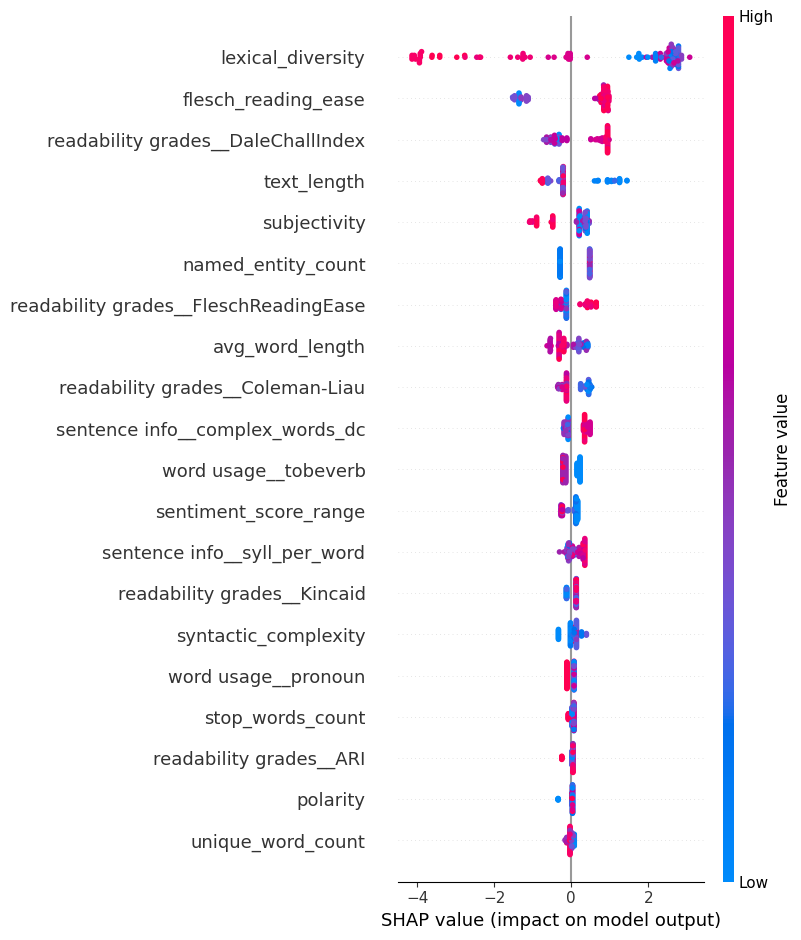

In [8]:
shap.summary_plot(shap_values, X)

In [9]:
# Select a sample index
sample_index = 4

# Calculate SHAP values for the selected sample while maintaining DataFrame structure
shap_values_single = explainer.shap_values(X_test.iloc[[sample_index]])

# Generate the force plot for class 0
# - `explainer.expected_value[0]` for the expected value of class 0
# - `shap_values_single[0][0]` to access the SHAP values for class 0 of the selected sample
shap.force_plot(
    explainer.expected_value,      # Base value (scalar)
    shap_values_single[0],         # SHAP values for the sample (array)
    X_test.iloc[sample_index]      # Feature values for the sample
)

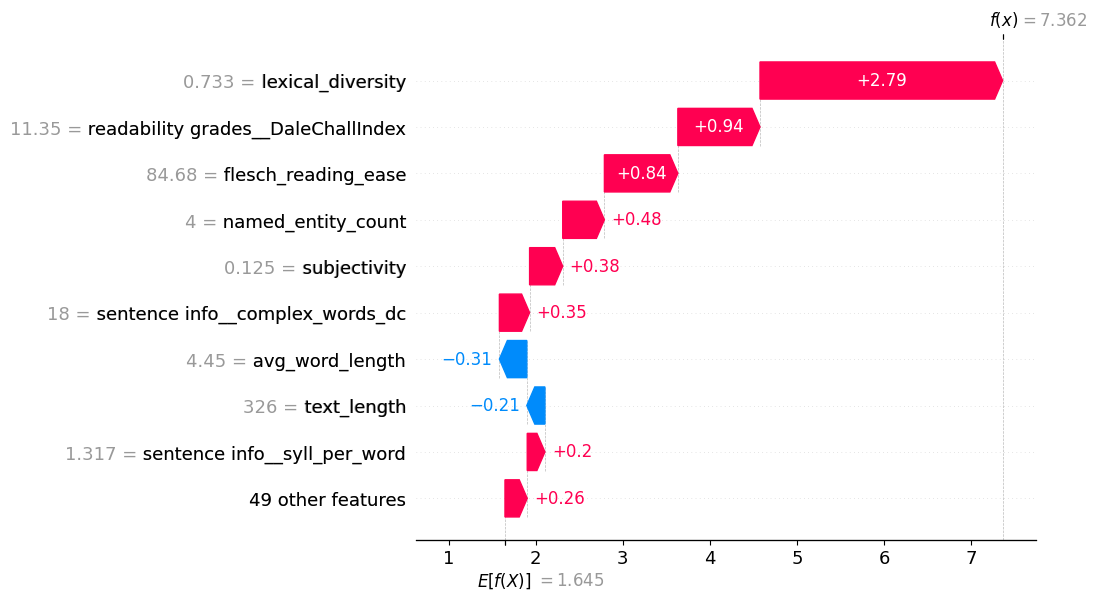

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[6])

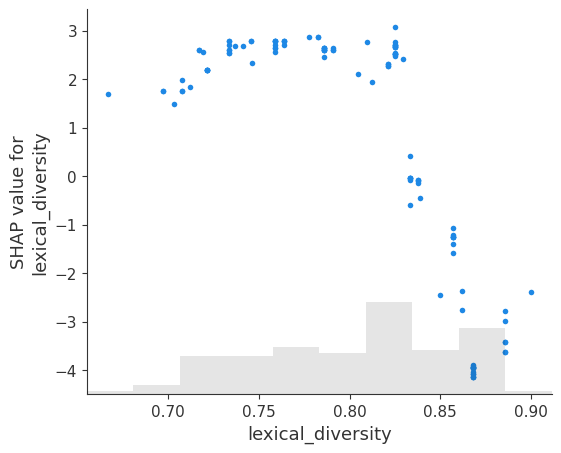

In [11]:
shap.plots.scatter(shap_values[:,"lexical_diversity"])

In [12]:
shap.plots.force(shap_values)

In [13]:
sample_index = 0
shap_values_single = explainer.shap_values(X_test.iloc[[sample_index]])

print("Expected Value:", explainer.expected_value)
print("Type of Expected Value:", type(explainer.expected_value))
print("Shape of SHAP values for single sample:", np.array(shap_values_single).shape)
print("Content of SHAP values for single sample:", shap_values_single)

Expected Value: 1.6450632
Type of Expected Value: <class 'numpy.float32'>
Shape of SHAP values for single sample: (1, 58)
Content of SHAP values for single sample: [[ 0.01342568  0.20748511  0.73948634 -0.33274665 -4.1371365  -0.6099911
   0.          0.         -0.5398114   0.00973137  0.13662145  0.
   0.         -0.2887144   0.          0.          0.          0.
   0.          0.          0.02126392  0.          0.13060969  0.01625139
  -0.33415863 -0.3942599   0.          0.          0.         -0.01624211
  -0.4347707   0.         -0.10625888  0.          0.         -0.05945476
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.18523416 -0.21549237  0.          0.
  -0.11294983  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]


In [14]:
X_test.iloc[sample_index]

polarity                                    0.000000
subjectivity                                0.000000
flesch_reading_ease                        87.210000
syntactic_complexity                       10.500000
lexical_diversity                           0.868421
text_length                               205.000000
question_marks                              1.000000
exclamation_marks                           0.000000
avg_word_length                             4.421053
unique_word_count                          33.000000
sentiment_score_range                       0.000000
noun_phrase_count                          10.000000
verb_phrase_count                           6.000000
named_entity_count                          2.000000
passive_voice_count                         0.000000
active_voice_count                          3.000000
modal_verbs_count                           0.000000
conditional_sentences_count                 0.000000
sentence_count                              4.

In [15]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4o")
# Load your dataset
data = pd.read_csv(file_name)

# Filter data to get only the cluster you are interested in
specific_cluster_data = data['text']
def count_tokens(text, encoder):
    tokens = encoder.encode(text)
    return len(tokens)

total_tokens = sum(specific_cluster_data.apply(lambda text: count_tokens(text, enc)))
print(f"Total number of tokens in cluster 7: {total_tokens}")

Total number of tokens in cluster 7: 6420


In [18]:
def count_tokens(text, encoder):
    tokens = encoder.encode(text)
    return len(tokens)

total_tokens = []
for i in range(20):  # Loop from 0_data.csv to 19_data.csv
    file_name = f'clusters csv\\{i}_data.csv'
    data = pd.read_csv(file_name)
    cluster_text = data['text']
    cluster_tokens = sum(cluster_text.apply(lambda text: count_tokens(text, enc)))
    total_tokens.append(cluster_tokens)
    print(f"Total number of tokens in cluster {i}: {cluster_tokens}")
    
sum(total_tokens)

Total number of tokens in cluster 0: 21652
Total number of tokens in cluster 1: 2712
Total number of tokens in cluster 2: 9169
Total number of tokens in cluster 3: 6073
Total number of tokens in cluster 4: 42370
Total number of tokens in cluster 5: 5366
Total number of tokens in cluster 6: 15964
Total number of tokens in cluster 7: 6420
Total number of tokens in cluster 8: 6412
Total number of tokens in cluster 9: 11308
Total number of tokens in cluster 10: 12736
Total number of tokens in cluster 11: 12076
Total number of tokens in cluster 12: 11952
Total number of tokens in cluster 13: 3072
Total number of tokens in cluster 14: 8610
Total number of tokens in cluster 15: 3516
Total number of tokens in cluster 16: 6344
Total number of tokens in cluster 17: 9743
Total number of tokens in cluster 18: 4402
Total number of tokens in cluster 19: 5361


205258

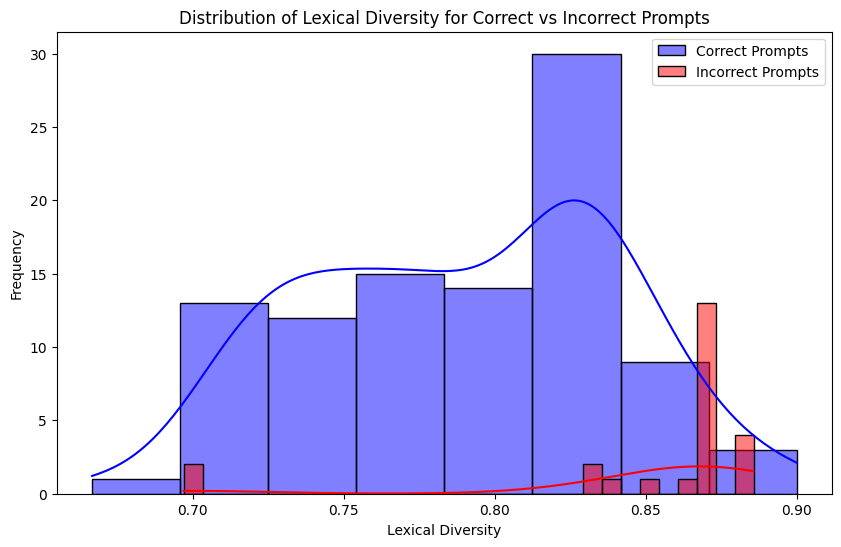

In [19]:
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data for cluster 7
file_name = 'clusters csv\\7_data.csv'
data = pd.read_csv(file_name)

# Filter by performance
correct_diversity = data[data['performance'] == 1]['lexical_diversity']
incorrect_diversity = data[data['performance'] == 0]['lexical_diversity']

plt.figure(figsize=(10, 6))
sns.histplot(correct_diversity, color='blue', kde=True, label='Correct Prompts')
sns.histplot(incorrect_diversity, color='red', kde=True, label='Incorrect Prompts')
plt.legend()
plt.title('Distribution of Lexical Diversity for Correct vs Incorrect Prompts')
plt.xlabel('Lexical Diversity')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Perform the Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(correct_diversity, incorrect_diversity, alternative='two-sided')

print(f'Mann-Whitney U statistic: {u_stat}')
print(f'P-value: {p_value}')

Mann-Whitney U statistic: 302.0
P-value: 1.984350831763871e-08
